# Classifying Traffic Signs with LeNet-5 Convolutional Neural Network

* Restructuring LeNet Convolutional Neural Network (CNN) to classify traffic sign plates;
* Last layer's number of neurons goes to 43: the number of classes in our traffic signs dataset;
* Dataset has 51.839 images of 43 different traffic sign plates. 34799 images are used for training, 4410 for validation and 12630 for testing;
* We convert every image to grayscale. Our LeNet is completely retrained, no transfer learning is performed;
* Implementation based on the LeNet-5 Architecture: http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf
* Dataset used: https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

In [ ]:
import os
import pickle
import zipfile

import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from tensorflow import keras
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report


---

To start our neural network development, we first need to prepare the chosen dataset. Our selected traffic signs dataset is given in a zipped folder in the project repository. It is possible to extract and load the files to memory using Python's standard libraries Zipfile and Pickle.

Then, we can print a portion of the loaded dictionary to get a grasp on some dataset details. The dictionary has the features themselves, the labels and other metadata.

In [ ]:
with open('../data/raw/train.p', mode='rb') as train_data:
    train_data = pickle.load(train_data)
with open('../data/raw/valid.p', mode='rb') as valid_data:
    valid_data = pickle.load(valid_data)
with open('../data/raw/test.p', mode='rb') as test_data:
    test_data = pickle.load(test_data)

In [ ]:
print("Image features example: \n", train_data['features'][:1])
print("\n\nImage labels: \n", train_data['labels'])

Image features example: 
 [[[[28 25 24]
   [27 24 23]
   [27 24 22]
   ...
   [32 28 24]
   [31 27 25]
   [31 27 26]]

  [[29 26 25]
   [27 25 23]
   [27 25 23]
   ...
   [32 28 24]
   [31 27 24]
   [30 27 25]]

  [[28 26 26]
   [27 25 23]
   [26 25 23]
   ...
   [32 28 24]
   [31 27 24]
   [30 27 25]]

  ...

  [[27 24 23]
   [28 25 24]
   [30 25 24]
   ...
   [27 24 23]
   [28 24 22]
   [29 25 22]]

  [[28 23 23]
   [29 24 24]
   [31 25 24]
   ...
   [27 24 23]
   [28 24 22]
   [28 24 21]]

  [[29 23 23]
   [30 24 24]
   [32 24 23]
   ...
   [27 24 22]
   [27 23 21]
   [26 22 20]]]]


Image labels: 
 [41 41 41 ... 25 25 25]


In [ ]:
X_train, y_train = train_data['features'], train_data['labels']
print("Training data shape: ", X_train.shape)
print("Training labels shape: ", y_train.shape)

X_validation, y_validation = valid_data['features'], valid_data['labels']
print("Validation data shape: ", X_validation.shape)
print("Validation labels shape: ", y_validation.shape)

X_test, y_test = test_data['features'], test_data['labels']
print("Testing data shape: ", X_test.shape)
print("Testing labels shape: ", y_test.shape)

Training data shape:  (34799, 32, 32, 3)
Training labels shape:  (34799,)
Validation data shape:  (4410, 32, 32, 3)
Validation labels shape:  (4410,)
Testing data shape:  (12630, 32, 32, 3)
Testing labels shape:  (12630,)



---

Printing the features and labels will not give us the actual look of the images that we are dealing with. We can build image grids having some randomly selected images along with their labels from the train and validation sets.

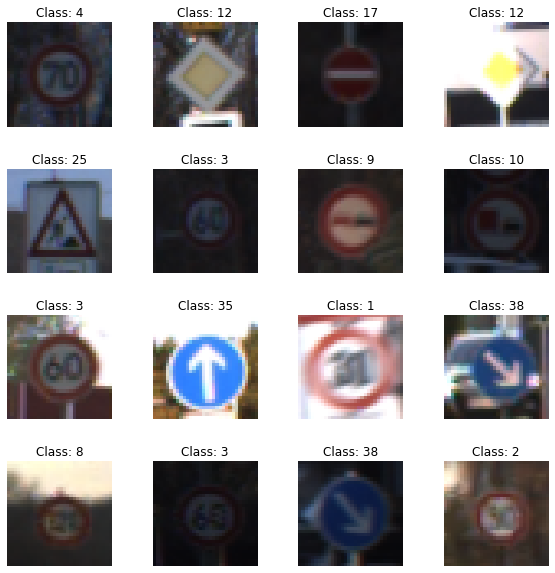

In [ ]:
# Image grid with 4x4 images.
grid_height = 4
grid_width = 4

fig, axes = plt.subplots(grid_height, grid_width, figsize=(10, 10))
axes = axes.ravel()

for i in range(grid_height * grid_width):
    # Draft random sample from the training set to plot with its label.
    drafted_index = np.random.randint(0, X_train.shape[0])
    axes[i].imshow(X_train[drafted_index])
    axes[i].set_title("Class: " + str(y_train[drafted_index]))
    axes[i].axis('off')
plt.subplots_adjust(hspace=0.4)

Traffic sign plates have very redundant colors in them and background colors may create noise. So, we can change the color scheme of our images to grayscale, to account for those aspects of our dataset. We may also rescale the pixel values from our dataset.

The changes will make the network train faster, meaning that we will have more time to evaluate different training hyperparameter configurations (number of epochs, batch size, early stopping, etc.).

In [ ]:
# Shuffle all sets to remove any bias from the original dataset.
X_train, y_train = shuffle(X_train, y_train)
X_validation, y_validation = shuffle(X_validation, y_validation)
X_test, y_test = shuffle(X_test, y_test)

# Convert every image in the training set to grayscale by averaging
# the pixel values from the 3 channels.
X_train_gray = np.sum(X_train / 3, axis=3, keepdims=True)
print(X_train_gray.shape)

X_validation_gray = np.sum(X_validation / 3, axis=3, keepdims=True)
print(X_validation_gray.shape)

X_test_gray = np.sum(X_test / 3, axis=3, keepdims=True)
print(X_test_gray.shape)

(34799, 32, 32, 1)
(4410, 32, 32, 1)
(12630, 32, 32, 1)


In [ ]:
# Rescale data to [0, 1) range by removing the median value and
# dividing by the possible maximum.
X_train_gray_norm = (X_train_gray - 128) / 128
X_validation_gray_norm = (X_validation_gray - 128) / 128
X_test_gray_norm = (X_test_gray - 128) / 128

print(np.max(X_train_gray_norm))

0.9921875


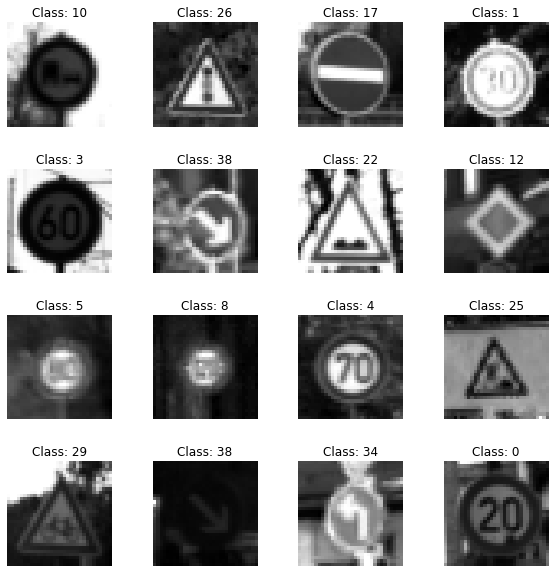

In [ ]:
# Image grid with 4x4 images.
grid_height = 4
grid_width = 4

fig, axes = plt.subplots(grid_height, grid_width, figsize=(10, 10))
axes = axes.ravel()

for i in range(grid_height * grid_width):
    # Draft random sample from the now grayscaled validation set.
    drafted_index = np.random.randint(0, X_validation.shape[0])
    axes[i].imshow(X_validation_gray_norm[drafted_index].squeeze(), cmap='gray')
    axes[i].set_title("Class: " + str(y_validation[drafted_index]))
    axes[i].axis('off')
plt.subplots_adjust(hspace=0.4)


---

Now we can reproduce the LeNet-5 architecture as it was proposed in its original paper. Since the model has a single stream of layers, we can use the `Sequential()` Keras framework to build it, adding layers on top of each other sequentially.

The model takes 32x32 images as input, the same resolution already present in our dataset. It uses two convolutional layers, one with 6 filters and the other with 16, both with 5x5 filter size and 1x1 stride. After each convolutional layer, there is an average pooling layer with 2x2 pool size and stride; summarizing the values from each convolutional filter.

The convolutions act as image feature extractors. The LeNet-5 architecture was proposed to deal with 32x32 images of handwritten digits. However, it can work well for other types of images having symbols, if the 32x32 dimensions are kept.

After the second average pooling layer there is a layer flattening the extracted features to be passed to the fully connected (dense) layers. There are 3 fully connected layers: one with 120 neurons; the next with 84 neurons; and the last with number of neurons equal to the number of classes of the problem, in our case, 43.

Every layer in the network uses ReLU as activation function, except for the last layer, which uses softmax.

In [ ]:
le_net_model = keras.models.Sequential()

le_net_model.add(keras.layers.Conv2D(6, (5, 5), activation='relu',
                               input_shape=(32, 32, 1)))
le_net_model.add(keras.layers.AveragePooling2D())

le_net_model.add(keras.layers.Conv2D(16, (5, 5), activation='relu'))
le_net_model.add(keras.layers.AveragePooling2D())

le_net_model.add(keras.layers.Flatten())

le_net_model.add(keras.layers.Dense(units=120, activation='relu'))
le_net_model.add(keras.layers.Dense(units=84, activation='relu'))

# 43 neurons instead of the originally proposed 10, as our task has
# 43 classes.
le_net_model.add(keras.layers.Dense(units=43, activation='softmax'))

le_net_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d_6 (Averag  (None, 14, 14, 6)        0         
 ePooling2D)                                                     
                                                                 
 conv2d_7 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_7 (Averag  (None, 5, 5, 16)         0         
 ePooling2D)                                                     
                                                                 
 flatten_3 (Flatten)         (None, 400)               0         
                                                                 
 dense_9 (Dense)             (None, 120)              

In [ ]:
# Patience empirically tested and set to 10.
early_stopping_callback = keras.callbacks.EarlyStopping(patience=10,
                                                        restore_best_weights=True)

# We use 200 batches of images.
batch_size = X_train_gray_norm.shape[0] // 200

le_net_model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy',
                     metrics = 'accuracy')

# 100 epochs are enough to train our neural network with 64,511
# parameters. Using grayscale-converted images to train and validate.
epochs_info = le_net_model.fit(X_train_gray_norm,
                               y_train,
                               batch_size=batch_size,
                               epochs=100,
                               callbacks=[early_stopping_callback],
                               validation_data=(X_validation_gray_norm,
                                                y_validation))

Epoch 1/100
202/202 [==============================] - 17s 84ms/step - loss: 2.2546 - accuracy: 0.3973 - val_loss: 1.2677 - val_accuracy: 0.6406
Epoch 2/100
202/202 [==============================] - 17s 83ms/step - loss: 0.7531 - accuracy: 0.7894 - val_loss: 0.8198 - val_accuracy: 0.7667
Epoch 3/100
202/202 [==============================] - 17s 83ms/step - loss: 0.4719 - accuracy: 0.8700 - val_loss: 0.6516 - val_accuracy: 0.8175
Epoch 4/100
202/202 [==============================] - 18s 90ms/step - loss: 0.3497 - accuracy: 0.9046 - val_loss: 0.5808 - val_accuracy: 0.8290
Epoch 5/100
202/202 [==============================] - 17s 85ms/step - loss: 0.2738 - accuracy: 0.9261 - val_loss: 0.5643 - val_accuracy: 0.8415
Epoch 6/100
202/202 [==============================] - 17s 82ms/step - loss: 0.2216 - accuracy: 0.9410 - val_loss: 0.5430 - val_accuracy: 0.8560
Epoch 7/100
202/202 [==============================] - 17s 83ms/step - loss: 0.1835 - accuracy: 0.9519 - val_loss: 0.5330 - val_ac


---

As we can see in the loss and accuracy progression plots below, the validation metrics stabilize before 10 epochs of training. We can also see that the model starts overfitting at the very beginning, with the training loss having a much steeper curve than the validation loss.

Nonetheless, the validation accuracy does not drop after stabilizing and the best "val_loss" weights are restored in our early stopping callback. Hence, it was decided to let the model train until convergence on the training set.

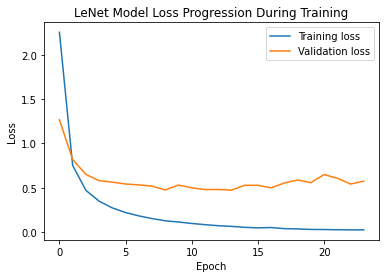

In [ ]:
plt.plot(epochs_info.history['loss'])
plt.plot(epochs_info.history['val_loss'])
plt.title("LeNet Model Loss Progression During Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["Training loss", "Validation loss"])
plt.show()

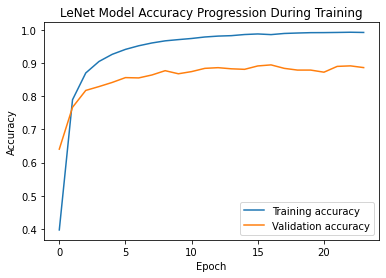

In [ ]:
plt.plot(epochs_info.history['accuracy'])
plt.plot(epochs_info.history['val_accuracy'])
plt.title("LeNet Model Accuracy Progression During Training")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Training accuracy", "Validation accuracy"])
plt.show()


---

Using Keras own `evaluate` function for sequential models, we are able to measure an accuracy of approximately 87%.

Looking at the confusion matrix obtained from the model predictions, we can see that most samples were correctly classified. Seaborn library's `heatmap` using the confusion matrix can help us visualize that.

Finally, the classification report from Scikit-learn indicates the same accuracy reported by the `evaluate` function: 87%. Precision and recall measures can also be seen for each class.

In [ ]:
le_net_model.evaluate(X_test_gray_norm, y_test)

395/395 [==============================] - 5s 13ms/step - loss: 1.0650 - accuracy: 0.8732


[1.065018653869629, 0.8731591701507568]

In [ ]:
# Predict classes with our model and get class with the largest
# probability returned by the softmax activation function.
y_pred = le_net_model.predict(X_test_gray_norm)
y_pred_classes = np.argmax(y_pred, axis=1)

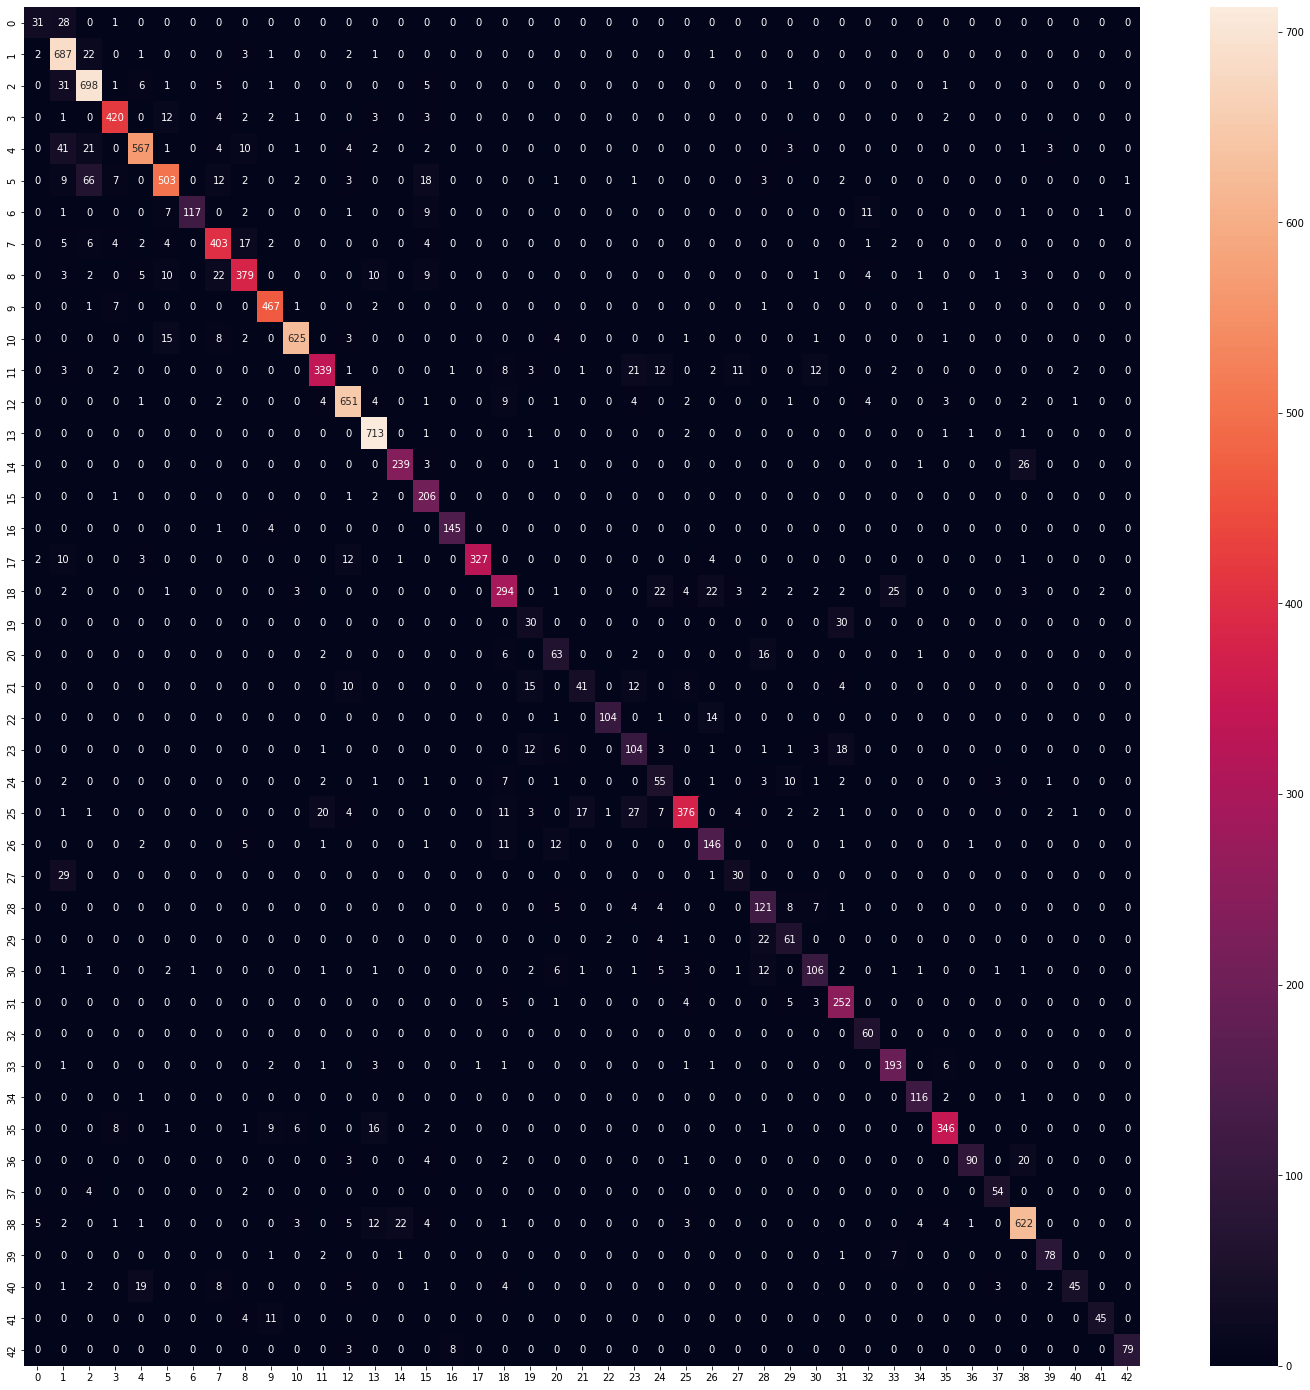

In [ ]:
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(25, 25))
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

In [ ]:
print(classification_report(y_test, y_pred_classes))

              precision    recall  f1-score   support

           0       0.78      0.52      0.62        60
           1       0.80      0.95      0.87       720
           2       0.85      0.93      0.89       750
           3       0.93      0.93      0.93       450
           4       0.93      0.86      0.89       660
           5       0.90      0.80      0.85       630
           6       0.99      0.78      0.87       150
           7       0.86      0.90      0.88       450
           8       0.88      0.84      0.86       450
           9       0.93      0.97      0.95       480
          10       0.97      0.95      0.96       660
          11       0.91      0.81      0.85       420
          12       0.92      0.94      0.93       690
          13       0.93      0.99      0.96       720
          14       0.91      0.89      0.90       270
          15       0.75      0.98      0.85       210
          16       0.94      0.97      0.95       150
          17       1.00    

We create another image grid to visualize our model results. This time, we randomly draft images from the colored testing set. Actual and predicted labels are printed above each image in the grid.

With this visualization we can see that our model has problems dealing with images that have bad quality. Images that are too dark, with too much jittering or bad overall are misclassified (e.g. row 3, column 5 in the grid). For these cases, image preprocessing to improve lighting or reduce blur would help. We are not covering that on this notebook since we want to deal with the original images.

We can also see some cases where our classifier should have been able to correctly classify the traffic sign, as in row 7, column 7. This means that there is room for improvement over LeNet-5's performance. Since this is a showcase using LeNet CNN, we are not going to try to change its architecture, ultimately creating a new CNN.

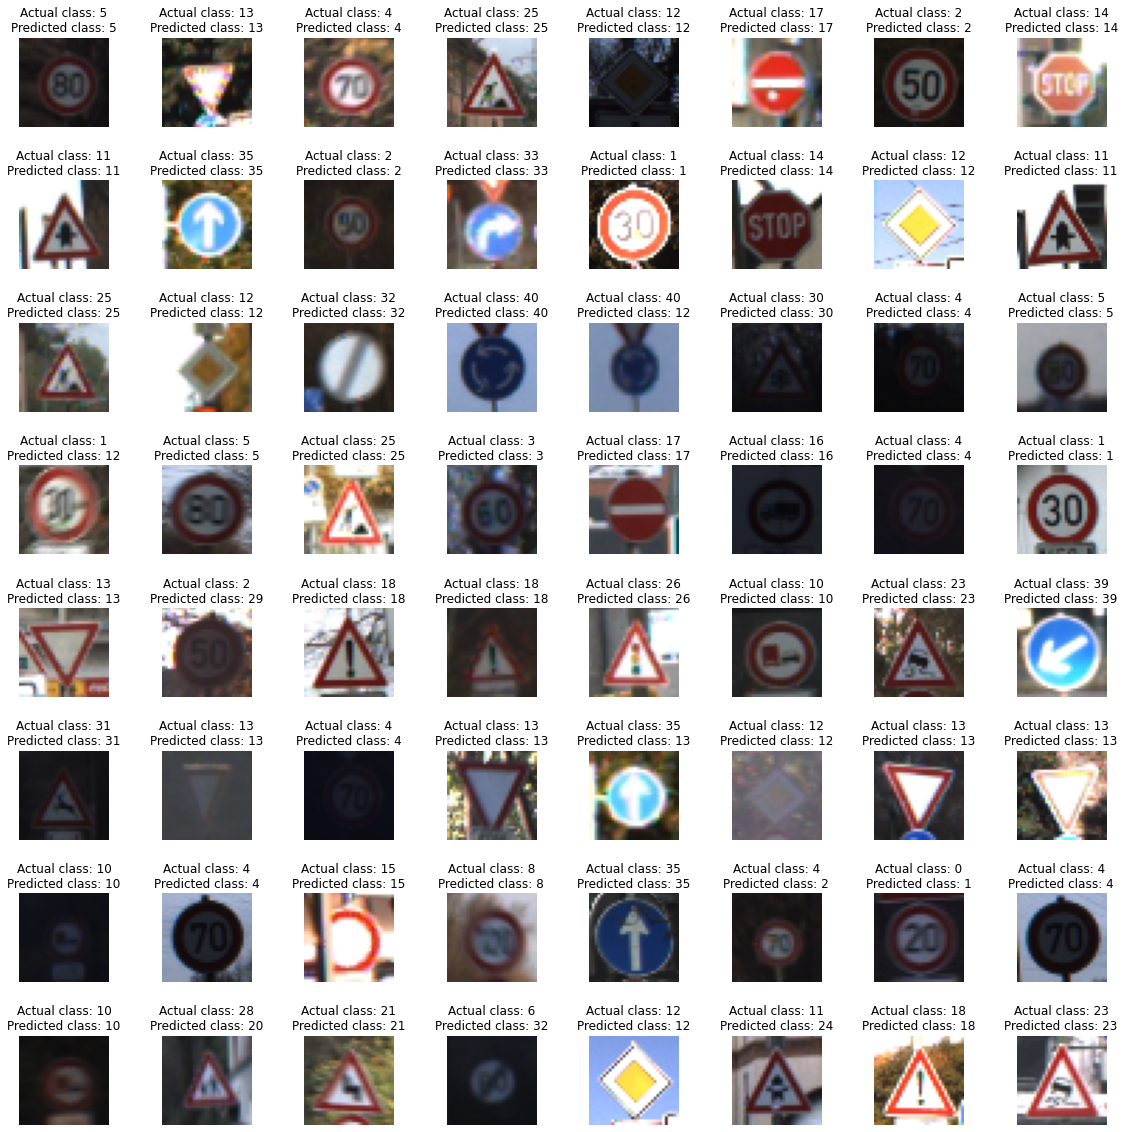

In [ ]:
# Image grid with 8x8 images.
grid_height = 8
grid_width = 8

fig, axes = plt.subplots(grid_height, grid_width, figsize=(20, 20))
axes = axes.ravel()

for i in range(0, grid_height * grid_width):
    # Draft random sample from the testing set to plot with labels.
    drafted_index = np.random.randint(0, X_test_gray_norm.shape[0])
    axes[i].imshow(X_test[drafted_index])
    axes[i].set_title(
        "Actual class: {}\nPredicted class: {}"
        .format(y_test[drafted_index], y_pred_classes[drafted_index])
    )
    axes[i].axis('off')
plt.subplots_adjust(hspace=0.6)